# PART A

In [53]:
import random

# Function to get the list of sum of the upward face value of n rolls for 1000 repititions
def roll_biased_die(k, n):
    results = []
    weights = [1 / (2 ** (k - 1))] + [1 / (2 ** (i - 1)) for i in range(2, k + 1)]
    for _ in range(1000):
        outcome = random.choices(range(1, k + 1), weights=weights, k=n)
        results.append(sum(outcome))
    
    return results

In [54]:
# To calculate probability with sum S for k faced dice rolled n times
def probability_sum(n, k, S):
    
    dp = [[0.0] * (S + 1) for _ in range(n + 1)]
    dp[0][0] = 1.0

    for i in range(1, n + 1):
        for j in range(1, S + 1):
            for face in range(1, k + 1):
                if j >= face:
                    if face == 1:
                        dp[i][j] += dp[i - 1][j - face] * (1 / (2 ** (k - 1)))
                    else:
                        dp[i][j] += dp[i - 1][j - face] * (1 / (2 ** (face - 1)))

    return dp

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def fun(k, rolls):
    # Simulate die rolls and calculate the sum
    results = roll_biased_die(k, rolls)
    
    # Plot a frequency distribution histogram
    plt.hist(results)
    plt.xlabel("Sum of Upward Face Values")
    plt.ylabel("Frequency")
    plt.title(f"Frequency Distribution for {rolls} Rolls of a {k}-Faced Die")
    plt.show()

    # Calculate the theoretical expected sum
    dp = probability_sum(rolls,k,k*rolls)
    expected_sum_theoretical = 0
    for i in range(1,rolls*k+1):
        expected_sum_theoretical += i*dp[rolls][i]
    
    
    # Calculate the actual expected sum from the simulation
    expected_sum_actual = np.mean(results)
    
    print(f"Theoretical Expected Sum: {expected_sum_theoretical:.4f}")
    print(f"Actual Sum: {expected_sum_actual:.4f}")

    print("------------------------------------------------------")
    
    # Print the five-number summary
    summary = np.percentile(results, [0, 25, 50, 75, 100])
    print(f"Minimum: {summary[0]}")
    print(f"1st Quartile: {summary[1]}")
    print(f"Median: {summary[2]}")
    print(f"3rd Quartile: {summary[3]}")
    print(f"Maximum: {summary[4]}")


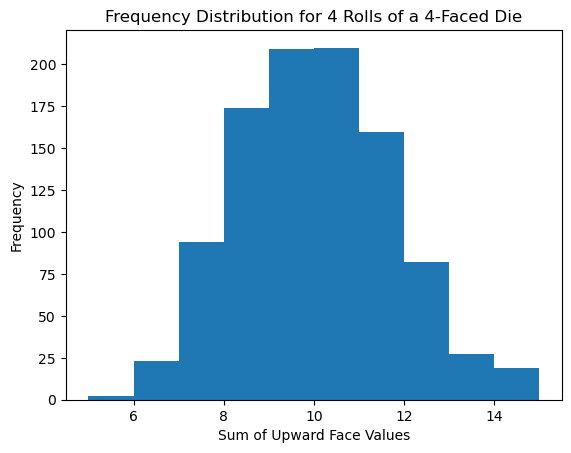

Theoretical Expected Sum: 9.5000
Actual Sum: 9.5430
------------------------------------------------------
Minimum: 5.0
1st Quartile: 8.0
Median: 9.0
3rd Quartile: 11.0
Maximum: 15.0


In [56]:
fun(4,4)

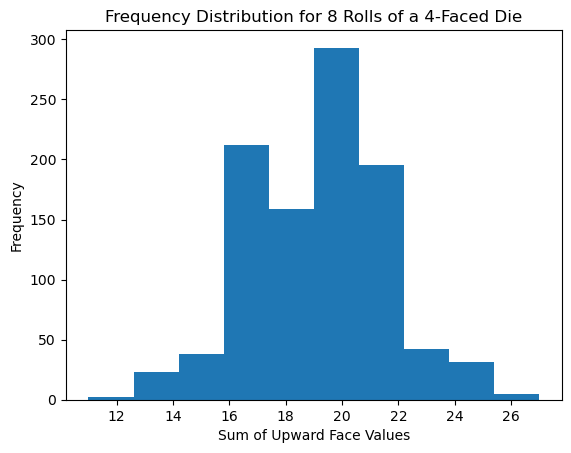

Theoretical Expected Sum: 19.0000
Actual Sum: 19.0100
------------------------------------------------------
Minimum: 11.0
1st Quartile: 17.0
Median: 19.0
3rd Quartile: 21.0
Maximum: 27.0


In [57]:
fun(4,8)

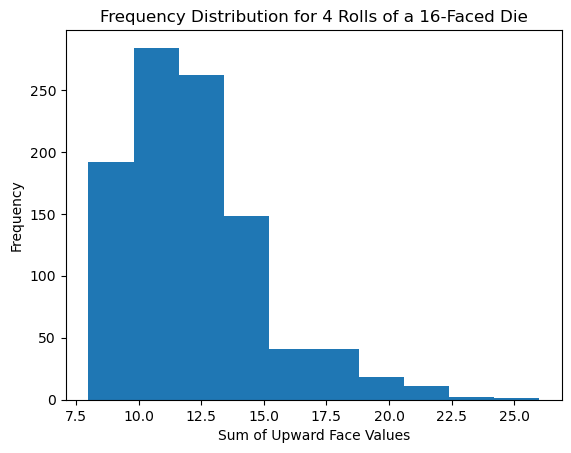

Theoretical Expected Sum: 11.9979
Actual Sum: 12.0790
------------------------------------------------------
Minimum: 8.0
1st Quartile: 10.0
Median: 12.0
3rd Quartile: 14.0
Maximum: 26.0


In [58]:
fun(16,4)

# PART B

### Loading Dataset

In [59]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

spambase = fetch_ucirepo(id=94)
X = spambase.data.features
y = spambase.data.targets
y = y.iloc[:, 0]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Plot Distribution of 5 columns 

In [60]:
import matplotlib.pyplot as plt

mean_values = []
for col in range(0,54):
    a = X_train.to_numpy()[:, col]
    mean_values.append(np.mean(a))
indices = np.argsort(mean_values)[-5:][::-1]

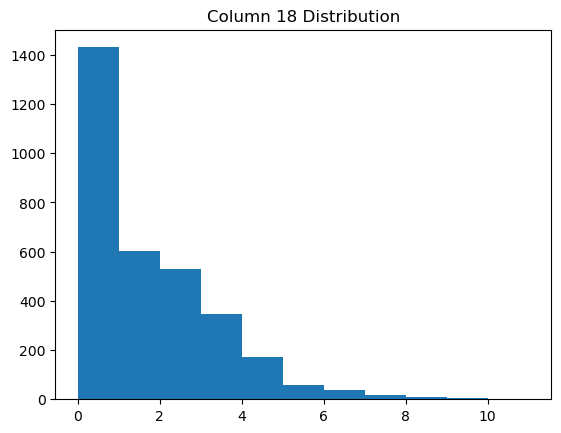

In [61]:
col = indices[0]
a = X_train.to_numpy()[:, col]    
plt.hist(a,bins = range(0,12))
plt.title(f'Column {col} Distribution')
plt.show()

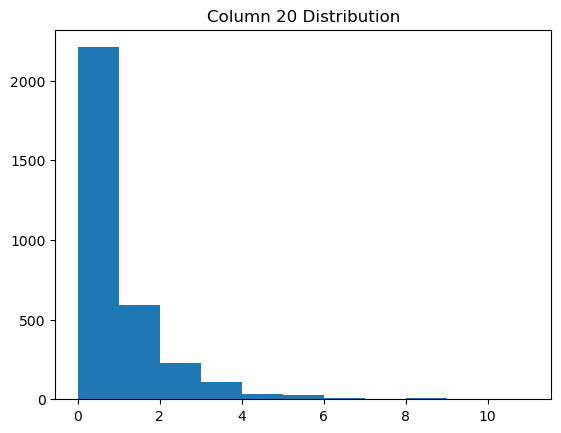

In [62]:
col = indices[1]
a = X_train.to_numpy()[:, col]    
plt.hist(a,bins = range(0,12))
plt.title(f'Column {col} Distribution')
plt.show()

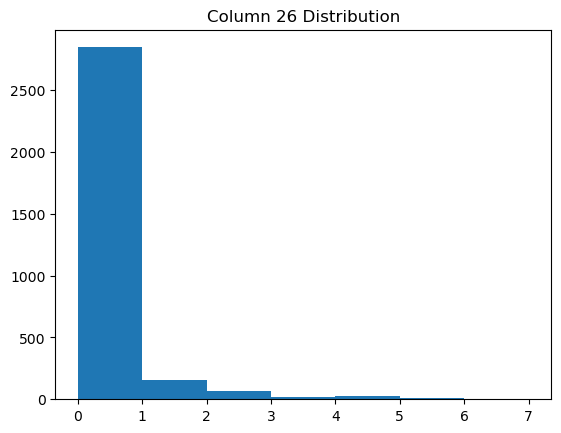

In [63]:
col = indices[2]
a = X_train.to_numpy()[:, col]    
plt.hist(a,bins = range(0,8))
plt.title(f'Column {col} Distribution')
plt.show()

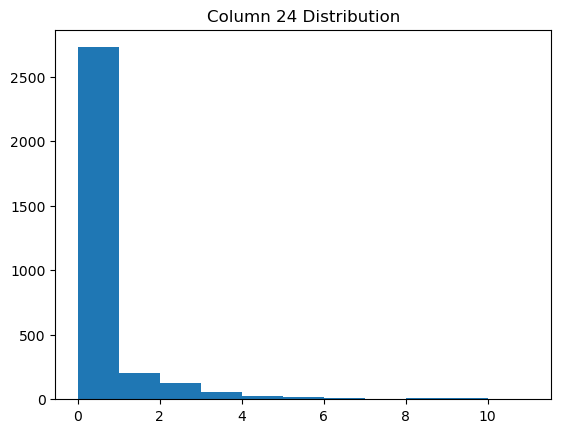

In [64]:
col = indices[3]
a = X_train.to_numpy()[:, col]    
plt.hist(a,bins = range(0,12))
plt.title(f'Column {col} Distribution')
plt.show()

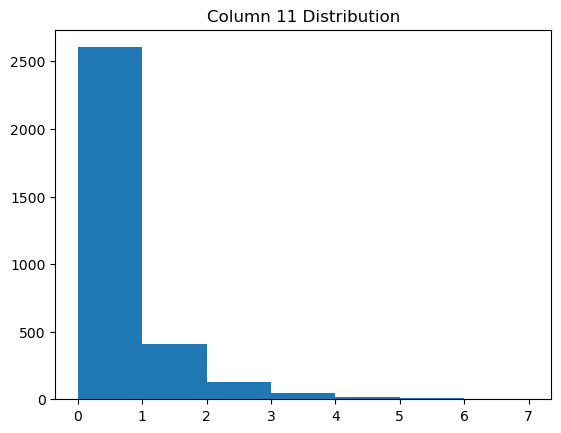

In [65]:
col = indices[4]
a = X_train.to_numpy()[:, col]    
plt.hist(a,bins = range(0,8))
plt.title(f'Column {col} Distribution')
plt.show()

### Priors of Classes

In [66]:
prior_spam = float(np.sum(y_train == 1) / len(y_train))
prior_not_spam = float(np.sum(y_train == 0) / len(y_train))

print(f'Prior Probability of Spam: {prior_spam}')
print(f'Prior Probability of Not Spam: {prior_not_spam}')

Prior Probability of Spam: 0.3838509316770186
Prior Probability of Not Spam: 0.6161490683229813


### Naive Bayes Classifier

In [67]:
class NaiveBayesClassifier():

    def calc_prior(self, features, target):
        
        self.prior = (features.groupby(target).apply(lambda x: len(x)) / self.rows).to_numpy()

        return self.prior
    
    def calc_statistics(self, features, target):

        self.mean = features.groupby(target).apply(np.mean, axis=0).to_numpy()
        self.var = features.groupby(target).apply(np.var, axis=0).to_numpy()
              
        return self.mean, self.var
    
    def gaussian_density(self, class_idx, x):     

        mean = self.mean[class_idx]
        var = self.var[class_idx]
        epsilon = 1e-10
        numerator = np.exp((-1/2)*((x-mean)**2) / (2 * (var + epsilon)))
        denominator = np.sqrt(2 * np.pi * (var + epsilon))
        prob = numerator / denominator
        return prob
    
    def calc_posterior(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for i in range(self.count):
            prior = np.log(self.prior[i]) ## use the log to make it more numerically stable
            conditional = np.sum(np.log(self.gaussian_density(i, x))) # use the log to make it more numerically stable
            posterior = prior + conditional
            posteriors.append(posterior)
            
        # return class with highest posterior probability
        return self.classes[np.argmax(posteriors)]
    
    def total_parameters(self):
        # Calculate the total number of parameters needed to be stored for the model
        # Parameters to store include prior, mean, and variance
        total_parameters = self.count + self.count * self.feature_nums * 2
        return total_parameters
    
    def predict_proba(self, features):
        # Initialize an empty array to store the class probabilities
        class_probabilities = np.zeros((features.shape[0], self.count))

        for i in range(self.count):
            # Calculate the log of the prior probability
            prior = np.log(self.prior[i])

            # Calculate the log of the conditional probability
            conditional = np.sum(np.log(self.gaussian_density(i, features)), axis=1)  # Sum along axis 1

            # Calculate the posterior probability (log scale)
            posterior = prior + conditional

            # Store the posterior probability for the current class
            class_probabilities[:, i] = posterior

        # Calculate class probabilities using the log-sum-exp trick for numerical stability
        # This step converts log-probabilities to probabilities
        log_class_probabilities = class_probabilities - np.max(class_probabilities, axis=1, keepdims=True)
        class_probabilities = np.exp(log_class_probabilities)

        # Normalize the probabilities to sum to 1 for each data point
        class_probabilities /= class_probabilities.sum(axis=1, keepdims=True)

        return class_probabilities
    
    def fit(self, features, target):
        self.classes = np.unique(target)
        self.count = len(self.classes)
        self.feature_nums = features.shape[1]
        self.rows = features.shape[0]
        
        self.calc_statistics(features, target)
        self.calc_prior(features, target)
        
    def predict(self, features):
        preds = [self.calc_posterior(f) for f in features.to_numpy()]
        return preds
    

### Train the model

In [68]:
my_model = NaiveBayesClassifier()
my_model.fit(X_train, y_train)

print(f'Number of parameters to be stored: {my_model.total_parameters()}')

Number of parameters to be stored: 230


### Evaluate the model

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(classifier, X, y):
    y_pred = classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = evaluate_model(my_model, X_test, y_test)
print("Naive Bayes Model Performance:")
print("-------------------------------")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Naive Bayes Model Performance:
-------------------------------
Accuracy: 0.8002894356005789
Precision: 0.6840796019900498
Recall: 0.9615384615384616
F1-score: 0.7994186046511628


C:\Users\user\AppData\Local\Temp\ipykernel_4856\3306703780.py:32: RuntimeWarning: divide by zero encountered in log
  conditional = np.sum(np.log(self.gaussian_density(i, x))) # use the log to make it more numerically stable


### Apply Log Transformation

In [70]:
X_train_log = X_train.apply(lambda x: np.log(x + 1))
X_val_log = X_val.apply(lambda x: np.log(x + 1))
X_test_log = X_test.apply(lambda x: np.log(x + 1))

# Evaluate the model with log-transformed data
accuracy_log, precision_log, recall_log, f1_log = evaluate_model(my_model, X_test_log, y_test)
print("Naive Bayes Model Performance (with log transformation):")
print("---------------------------------------------------------")
print(f"Accuracy: {accuracy_log}")
print(f"Precision: {precision_log}")
print(f"Recall: {recall_log}")
print(f"F1-score: {f1_log}")

Naive Bayes Model Performance (with log transformation):
---------------------------------------------------------
Accuracy: 0.7264833574529667
Precision: 0.6061269146608315
Recall: 0.9685314685314685
F1-score: 0.7456258411843876


C:\Users\user\AppData\Local\Temp\ipykernel_4856\3306703780.py:32: RuntimeWarning: divide by zero encountered in log
  conditional = np.sum(np.log(self.gaussian_density(i, x))) # use the log to make it more numerically stable


### Observation 

After applying log transformation, the accuracy, precision, recall and f1-scores got reduced.

# PART C

### GaussianNB from sklearn

In [71]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB(var_smoothing=1e-09)
gnb.fit(X_train, y_train)


accuracy, precision, recall, f1 = evaluate_model(gnb, X_test, y_test)
print("Gaussian Naive Bayes Model Performance:")
print("----------------------------------------")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Gaussian Naive Bayes Model Performance:
----------------------------------------
Accuracy: 0.8277858176555717
Precision: 0.7191601049868767
Recall: 0.958041958041958
F1-score: 0.8215892053973014


In [72]:
# Evaluate the model with log-transformed data

accuracy_log, precision_log, recall_log, f1_log = evaluate_model(gnb, X_test_log, y_test)
print("Gaussian Naive Bayes Model Performance (with log transformation):")
print("------------------------------------------------------------------")
print(f"Accuracy: {accuracy_log}")
print(f"Precision: {precision_log}")
print(f"Recall: {recall_log}")
print(f"F1-score: {f1_log}")

Gaussian Naive Bayes Model Performance (with log transformation):
------------------------------------------------------------------
Accuracy: 0.788712011577424
Precision: 0.6699029126213593
Recall: 0.965034965034965
F1-score: 0.7908309455587392


### ROC Curve

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


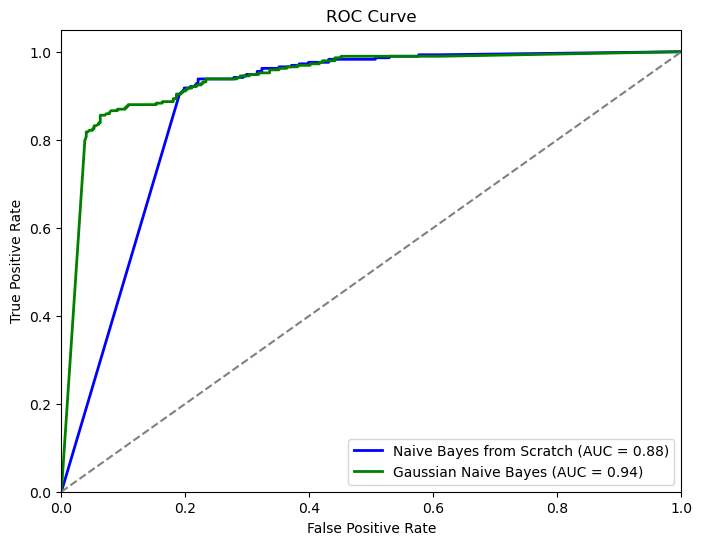

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve and AUC for Naive Bayes from scratch
y_scores_nb = my_model.predict_proba(X_val)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_val, y_scores_nb)
roc_auc_nb = roc_auc_score(y_val, y_scores_nb)

# Calculate ROC curve and AUC for Gaussian Naive Bayes from scikit-learn
y_scores_gnb = gnb.predict_proba(X_val)[:, 1]
fpr_gnb, tpr_gnb, _ = roc_curve(y_val, y_scores_gnb)
roc_auc_gnb = roc_auc_score(y_val, y_scores_gnb)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, color='blue', lw=2, label=f'Naive Bayes from Scratch (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_gnb, tpr_gnb, color='green', lw=2, label=f'Gaussian Naive Bayes (AUC = {roc_auc_gnb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Observations

Higher AUC for Gaussian Naive Bayes than the Naive Bayes Implemented. So GNB is better than Naive Bayes implemented for email spam classification.